In [1]:
import gym
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from collections import deque
import time
import random
from PIL import Image

RANDOM_SEED = 5
tf.random.set_seed(RANDOM_SEED)

In [2]:
env = gym.make('AssaultNoFrameskip-v0')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=True, scale_obs=True)

print("Action Space: {}".format(env.action_space))
print("State space: {}".format(env.observation_space))

Action Space: Discrete(7)
State space: Box([[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], [[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]], (84, 84, 1), float32)


In [3]:
from time import sleep

epochs, rewards = 0, 0
state = env.reset()
done = False

while not done:
    env.render()
    #sleep(0.1)
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    rewards  += reward
    epochs += 1
env.close()
print(f"Reward: {rewards}")  

C:\Users\robbe\AppData\Local\Programs\Python\Python39\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Kan threadmodus niet wijzigen nadat deze is ingesteld
  warnings.warn(str(err))


KeyboardInterrupt: 

In [20]:
Steps = []
for episode in range(100):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1.

        Steps.append(n_steps_episode)

np.mean(Steps) 

562.96

In [38]:
def agent(state_shape, action_shape):
  learning_rate = 0.001
  init = tf.keras.initializers.HeUniform()
  model = keras.Sequential() 
  model.add(keras.layers.Input(shape=(state_shape)))
  model.add(keras.layers.Conv2D(16,kernel_size=(3,3),strides=(2,2)))
  model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=(2,2)))
  model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=(2,2)))
  model.add(keras.layers.Conv2D(128, kernel_size=(3,3), strides=(2,2)))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2))) 
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(128, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(256, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

  return model

In [39]:
train_episodes = 250
test_episodes = 100

epsilon = 1 
max_epsilon = 1
min_epsilon = 0.01
decay = 0.0075

In [40]:
model = agent(env.observation_space.shape, env.action_space.n)
model.summary()
target_model = agent(env.observation_space.shape, env.action_space.n)

target_model.set_weights(model.get_weights())

replay_memory = deque(maxlen=50_000)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 41, 41, 16)        160       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 20, 20, 32)        4640      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 2, 2, 128)         512       
_________________________________________________________________
flatten_14 (Flatten)         (None, 512)             

In [41]:
def train(env, replay_memory, model, target_model, done):
    learning_rate = 0.7
    discount_factor = 0.618

    MIN_REPLAY_SIZE = 1000
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return
    
    
    
    batch_size = 500
    mini_batch = random.sample(replay_memory, batch_size)
    
    current_states = np.array([transition[0] for transition in mini_batch])
    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)
  
  
    X = []
    Y = []
    
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward
            
        current_qs = current_qs_list[index]
        current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        
        X.append(observation)
        Y.append(current_qs)
    
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [42]:
X = []
y = []
Steps = []

steps_to_update_target_model = 0

for episode in range(train_episodes):
    n_steps_episode = 0
    total_training_rewards = 0
    observation = env.reset()
    done = False
    while not done:
        steps_to_update_target_model += 1

        random_number = np.random.rand()
        if random_number <= epsilon:
            action = env.action_space.sample()
            
        else:
            observation_reshaped = np.array([observation],order = 'C')
            observation_reshaped.resize(1,84,84,1)
            observation_reshaped.shape
            #observation_reshaped = observation.reshape([1, observation.shape[0]])
            predicted = model.predict(observation_reshaped).flatten()
            action = np.argmax(predicted)
        new_observation, reward, done, info = env.step(action)
        total_training_rewards += reward
        replay_memory.append([observation, action, reward, new_observation, done])

        if steps_to_update_target_model % 4 == 0 or done:
            train(env, replay_memory, model, target_model, done)
        
        observation = new_observation
        
        n_steps_episode += 1
        
        if done:
            print('{} Total training rewards: {} after n steps = {}'.format(episode, total_training_rewards, n_steps_episode))
            Steps.append(n_steps_episode)

            if steps_to_update_target_model >= 100:
                target_model.set_weights(model.get_weights())
                steps_to_update_target_model = 0
            break
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)
env.close()

0 Total training rewards: 189.0 after n steps = 486
1 Total training rewards: 168.0 after n steps = 458
2 Total training rewards: 315.0 after n steps = 776
3 Total training rewards: 210.0 after n steps = 575
4 Total training rewards: 210.0 after n steps = 617
5 Total training rewards: 231.0 after n steps = 680
6 Total training rewards: 252.0 after n steps = 749
7 Total training rewards: 315.0 after n steps = 596
8 Total training rewards: 189.0 after n steps = 446
9 Total training rewards: 336.0 after n steps = 723
10 Total training rewards: 126.0 after n steps = 440
11 Total training rewards: 231.0 after n steps = 638
12 Total training rewards: 273.0 after n steps = 754
13 Total training rewards: 189.0 after n steps = 633
14 Total training rewards: 294.0 after n steps = 632
15 Total training rewards: 231.0 after n steps = 581
16 Total training rewards: 294.0 after n steps = 657
17 Total training rewards: 210.0 after n steps = 498
18 Total training rewards: 315.0 after n steps = 483
19 

KeyboardInterrupt: 

In [37]:
print(replay_memory)

deque([[array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32), 4, 0.0, array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        .

In [ ]:
def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
   
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(800, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    ax[1].tick_params(axis='x', colors='white')
    ax[1].tick_params(axis='y', colors='white')
    x = range(len(values))
    ax[0].legend()
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    ax[1].hist(values[-50:])
    ax[1].axvline(200, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].tick_params(axis='x', colors='white')
    ax[1].tick_params(axis='y', colors='white')
    ax[1].legend()
    plt.show()

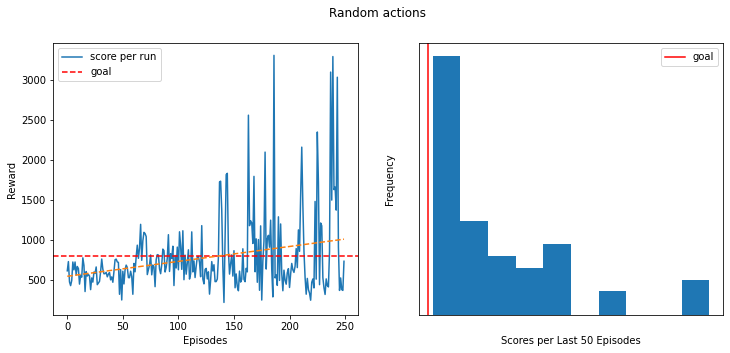

In [ ]:
plot_res(Steps,'Random actions')

In [ ]:
#import joblib
#model.save('assault_deepQ.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
epochs, rewards = 0, 0
observation = env.reset()
done = False

while not done:
    env.render()
    observation_reshaped = np.array([observation],order = 'C')
    observation_reshaped.resize(1,84,84,1)
    observation_reshaped.shape
    predicted = model.predict(observation_reshaped).flatten()
    action = np.argmax(predicted)
    state, reward, done, info = env.step(action)
    rewards  += reward
    epochs += 1
env.close()
print(f"Reward: {rewards}")  

Reward: 462.0


In [ ]:
Steps = []
for episode in range(test_episodes):
        n_steps_episode = 0
        total_training_rewards = 0
        observation = env.reset()
        done = False
        while not done:
            #observation_reshaped = observation.reshape([1, observation.shape[0]])
            observation_reshaped = np.array([observation],order = 'C')
            observation_reshaped.resize(1,84,84,1)
            observation_reshaped.shape
            predicted = model.predict(observation_reshaped).flatten()
            action = np.argmax(predicted)
            new_observation, reward, done, info = env.step(action)
            total_training_rewards += reward  
            observation = new_observation
            
            n_steps_episode += 1
        print('{} Total steps = {}'.format(episode,n_steps_episode))
        Steps.append(n_steps_episode)

0 Total steps = 468
1 Total steps = 324
2 Total steps = 689
3 Total steps = 501
4 Total steps = 514
5 Total steps = 546
6 Total steps = 675
7 Total steps = 418
8 Total steps = 672
9 Total steps = 583
10 Total steps = 646
11 Total steps = 523
12 Total steps = 340
13 Total steps = 676
14 Total steps = 875
15 Total steps = 630
16 Total steps = 326
17 Total steps = 502
18 Total steps = 608
19 Total steps = 600
20 Total steps = 515
21 Total steps = 626
22 Total steps = 563
23 Total steps = 563
24 Total steps = 610
25 Total steps = 229
26 Total steps = 540
27 Total steps = 545
28 Total steps = 448
29 Total steps = 637
30 Total steps = 582
31 Total steps = 625
32 Total steps = 548
33 Total steps = 642
34 Total steps = 484
35 Total steps = 510
36 Total steps = 512
37 Total steps = 482
38 Total steps = 473
39 Total steps = 672
40 Total steps = 469
41 Total steps = 326
42 Total steps = 642
43 Total steps = 596
44 Total steps = 647
45 Total steps = 484
46 Total steps = 228
47 Total steps = 727
48